In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
import geopandas as gpd
cwd = os.getcwd()
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('mode.chained_assignment', None) # Deshabilita SettingWithCopyWarning. Ojo.

In [2]:
df = pd.read_csv(cwd+"/train.csv", index_col='id', parse_dates=['fecha'])

In [3]:
"UNIFICO ALGUNOS VALORES"
df.loc[df['tipodepropiedad'] == 'Casa uso de suelo', 'tipodepropiedad'] = 'Casa'
df.loc[df['tipodepropiedad'] == 'Departamento Compartido', 'tipodepropiedad'] = 'Departamento'
df.loc[df['tipodepropiedad'] == 'Apartamento', 'tipodepropiedad'] = 'Departamento'
df.loc[df['tipodepropiedad'] == 'Edificio', 'tipodepropiedad'] = 'Departamento'
df.loc[df['tipodepropiedad'] == 'Local Comercial', 'tipodepropiedad'] = 'Oficina comercial'
df.loc[df['tipodepropiedad'] == 'Bodega comercial', 'tipodepropiedad'] = 'Oficina comercial'
df.loc[df['tipodepropiedad'] == 'Terreno comercial', 'tipodepropiedad'] = 'Oficina comercial'
df.loc[df['tipodepropiedad'] == 'Oficina Comercial', 'tipodepropiedad'] = 'Oficina comercial'
df.loc[df['tipodepropiedad'] == 'Local en centro comercial', 'tipodepropiedad'] = 'Oficina comercial'
df.loc[df['tipodepropiedad'] == 'Nave industrial', 'tipodepropiedad'] = 'Terreno industrial'

In [4]:
print("ANALISIS DEL PRECIO POR METRO CUADRADO EN FUNCION DEL TIEMPO (EN DISTRITO FEDERAL)")
df2 = df.copy()
df2['PRECIOM2'] = df2['precio']/df2['metrostotales']
df2_filtrado = df2[df2['provincia']=='Distrito Federal']

ANALISIS DEL PRECIO POR METRO CUADRADO EN FUNCION DEL TIEMPO (EN DISTRITO FEDERAL)


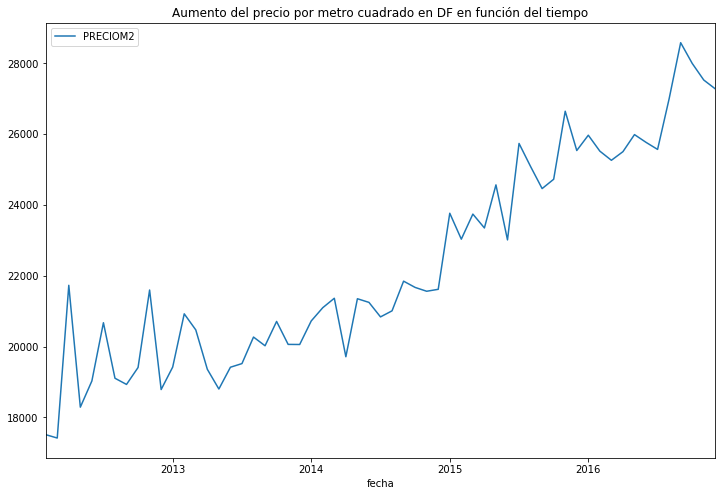

In [5]:
df2_filtrado['año'] = df2_filtrado['fecha'].dt.year
df2_filtrado['mes'] = df2_filtrado['fecha'].dt.month
df2_1 = df2_filtrado.groupby(['año','mes'])['PRECIOM2'].mean().reset_index()
df2_1['fecha'] = df2_1['año'] + df2_1['mes']/12
df2_1 = df2_1[df2_1['fecha']<=(2016+11/12)]
df2_1.plot.line(x='fecha',y='PRECIOM2',figsize=(12,8),title='Aumento del precio por metro cuadrado en DF en función del tiempo')

In [6]:
"COMPORTAMIENTO DEL PRECIO DEL METRO CUADRADO SEGUN TIPO DE PROPIEDAD"

df3 = df.copy()
df3['preciom2'] = df3['precio']/df3['metrostotales']
df3['anio'] = df3['fecha'].dt.year

tiposAFiltrar = ['Casa','Casa en condominio','Departamento','Terreno','Oficina comercial']

df3['filtro'] = df3['tipodepropiedad'].apply(lambda x: x in tiposAFiltrar)
df3 = df3[df3['filtro']]

Text(0.5, 1.0, 'Precio del Metro Cuadrado en función del tiempo (top 5 tipos de propiedad)')

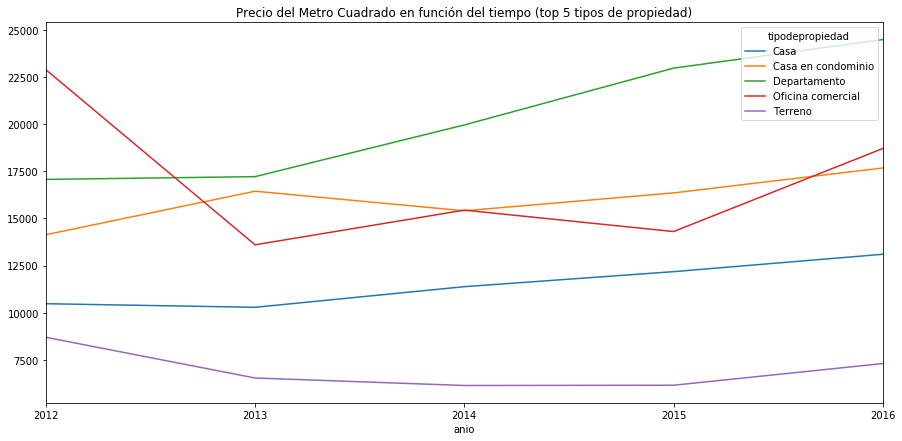

In [7]:
group3 = df3.groupby(['anio','tipodepropiedad'])['preciom2'].mean()
fig, ax = plt.subplots(figsize=(15,7))
group3.unstack().plot(ax=ax)
ticks = ax.xaxis.get_ticklocs()
ax.xaxis.set_ticks(ticks[0:10:2])
ax.xaxis.set_ticklabels(['2012','2013','2014','2015','2016']);
plt.title("Precio del Metro Cuadrado en función del tiempo (top 5 tipos de propiedad)")

In [8]:
"ESTA CELDA ES NECESARIA PARA CUALQUIER MAPA, PARA PONER LOS NOMBRES DE LOS ESTADOS"
from shapely.geometry import Point

geoframeCiudades = gpd.read_file(cwd+"/mexCiudades")

diccCorreccionNombres = {'San luis Potosí':'San Luis Potosí','Edo. de México':'México','Baja California Norte':'Baja California' }

def corregirNombre(x):
    if x in diccCorreccionNombres.keys():
        return diccCorreccionNombres[x]
    return x

puntosACorregir = {'Baja California Sur':(-2.8,-0.1),'Sinaloa':(1,0),'Sinaloa':(1,0),'Chihuahua':(-1.5,0),'Coahuila':(-2,2),
                  'Nuevo Leon':(-0.5,0),'Sinaloa':(-1.5,0),'Durango':(-1.6,0.8),'Nayarit':(-0.7,0),'Jalisco':(-1.5,-0.5),
                   'Guanajuato':(-1,0),'Guerrero':(-1.5,0.25),'Colima':(-2,-0.5),'Michoacan':(-2,-1),'Chiapas':(-0.25,-0.25)
                   ,'Tabasco':(-1,0),'Campeche':(-0.75,-0.75),'Quintana Roo':(-0.75,0),'Zacatecas':(-1.2,0.3),'Tamaulipas':(-1,1.6),
                   'Baja California':(-2.5,-4),'Mexico':(-0.8,-0.2),'Puebla':(-0.5,-0.75),'Guanajuato':(-1,-0.25),
                   'Queretaro':(0,-0.25),'Distrito Federal':(-0.7,-1),'Veracruz':(-0.25,0),'San Luis Potosi':(-0.2,0.2)
                   ,'Oaxaca':(-0.7,0)
                  }

def corregir(punto,tuplaXY):
    deltaX = tuplaXY[0]
    deltaY = tuplaXY[1]
    nuevoPunto = Point(punto.x+deltaX,punto.y+deltaY) 
    return nuevoPunto

def func(provincia, punto):
    if provincia in puntosACorregir.keys():
        return corregir(punto,puntosACorregir[provincia])
    return punto

geoframeCiudades['newGeometry'] = [func(geoframeCiudades.loc[idx, 'STATE_NAME'], geoframeCiudades.loc[idx, 'geometry'])
                                   for idx in range(len(geoframeCiudades))]

geoframeCiudadesCorregido = geoframeCiudades.drop('geometry',axis=1)
geoframeCiudadesCorregido.drop_duplicates(subset ="STATE_NAME", 
                     keep = 'first', inplace = True) 

estados_a_filtrar = ["Aguascalientes","Hidalgo","Tlaxcala","Morelos"]
def filtrar(x):
    return x not in estados_a_filtrar

geoframeCiudadesCorregido['aFiltrar'] = geoframeCiudades['STATE_NAME'].apply(filtrar)
geoframeC_C_Filtrado = geoframeCiudadesCorregido[geoframeCiudadesCorregido['aFiltrar']]
geoframeC_C_Filtrado.at[4,'STATE_NAME'] = 'DF'

In [9]:
"AUMENTO DEL PRECIO DEL METRO CUADRADO POR ESTADO EN EL ULTIMO ANIO"

df4 = df.copy()
df4['anio'] =df4['fecha'].dt.year
df4['aux'] = 1
df4['preciom2'] = df4['precio']/df4['metrostotales']
df4_1 = df4.groupby(['provincia','anio'])['preciom2'].mean().unstack().reset_index()

df4_1['provincia'] = df4_1['provincia'].apply(corregirNombre) #Corrije nombres de provincias para merge con geoframe
df4_1['diferencia'] = df4_1[2016]/df4_1[2015]
df4_1.sort_values(by='diferencia',ascending=False);

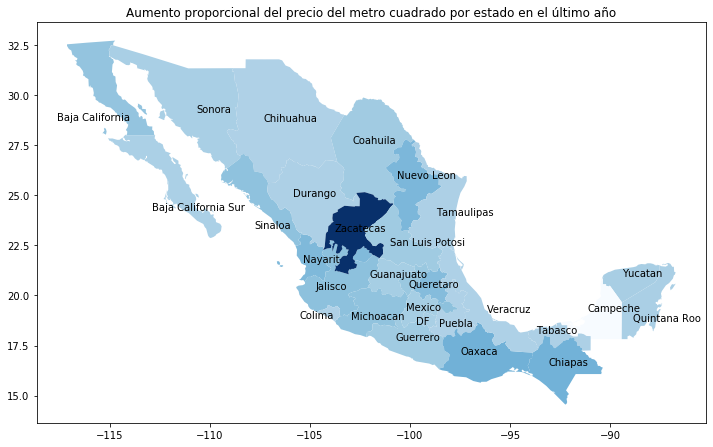

In [10]:
geoframe4 = gpd.read_file("C:/Users/Andres/Desktop/mexEstados")
merge4 = geoframe4.merge(df4_1,left_on='ESTADO',right_on='provincia')

geoplot4 = merge4.plot(figsize=(12,12),column='diferencia',legend=False,cmap='Blues')
geoplot4.set_title('Aumento proporcional del precio del metro cuadrado por estado en el último año')
for locacion,label in zip(geoframeC_C_Filtrado.newGeometry, geoframeC_C_Filtrado.STATE_NAME):
    geoplot4.annotate(label, xy=(locacion.x,locacion.y), xytext=(3, 3), textcoords="offset points")
plt.show()

In [11]:
"PRECIO PROMEDIO DEL METRO CUADRADO POR ESTADO"
df5 = df.copy()
df5['preciom2'] = df5.precio/df5.metrostotales
df5_1 = df5.groupby('provincia')['preciom2'].mean().reset_index()
df5_1['provincia'] = df5_1['provincia'].apply(corregirNombre)

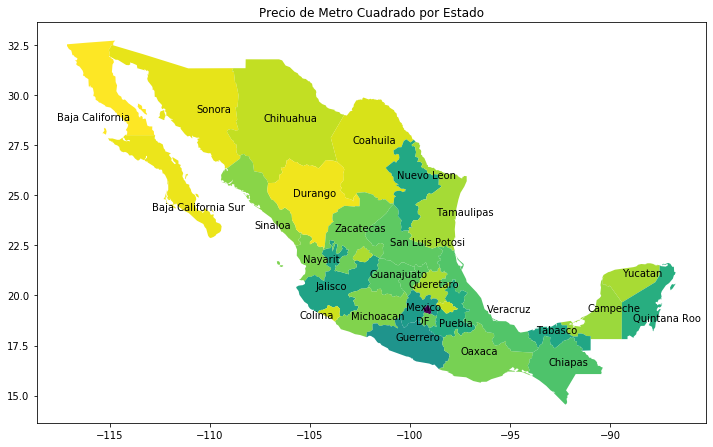

In [12]:
geoframe5 = gpd.read_file("C:/Users/Andres/Desktop/mexEstados")
merge5 = geoframe5.merge(df5_1,left_on="ESTADO",right_on="provincia")

geoplot5 = merge5.plot(figsize=(12,12),column='preciom2',legend=False,cmap='viridis_r')
plt.title("Precio de Metro Cuadrado por Estado")
for locacion,label in zip(geoframeC_C_Filtrado.newGeometry, geoframeC_C_Filtrado.STATE_NAME):
    geoplot5.annotate(label, xy=(locacion.x,locacion.y), xytext=(3, 3), textcoords="offset points")
plt.show()

In [13]:
"TIPO DE PROPIEDAD MAS CARO POR ESTADO"

df6 = df.copy()
df6['preciom2'] = df6['precio']/df6['metrostotales']
df6_1 = df6.groupby(['provincia','tipodepropiedad'])['preciom2'].mean().reset_index()
df6_2 = df6_1.loc[df6_1.groupby('provincia')['preciom2'].idxmax()]

In [14]:
df6_3 = df.copy()
df6_3['aux'] = 1
df6_4 = df6_3.groupby(['provincia','tipodepropiedad'])['aux'].count().reset_index()

In [15]:
merge6 = df6_1.merge(df6_4,on=['provincia','tipodepropiedad'])
merge6_filtrado = merge6[merge6['aux']>10] #Filtro los tipos de propiedades con poca cantidad
df6_5 = merge6_filtrado.loc[merge6_filtrado.groupby('provincia')['preciom2'].idxmax()]
df6_5['provincia'] = df6_5['provincia'].apply(corregirNombre)

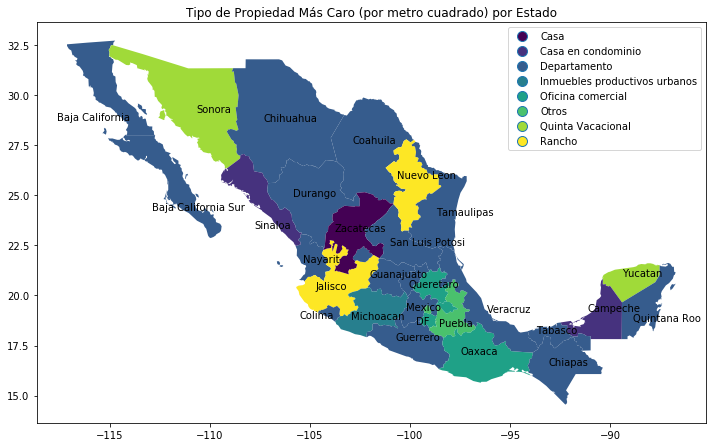

In [16]:
geoframe6 = gpd.read_file("C:/Users/Andres/Desktop/mexEstados")
merge6_1 = geoframe6.merge(df6_5,left_on='ESTADO',right_on='provincia')

geoplot6 = merge6_1.plot(figsize=(12,12),column='tipodepropiedad',legend=True,cmap='viridis')
geoplot6.set_title('Tipo de Propiedad Más Caro (por metro cuadrado) por Estado')
for locacion,label in zip(geoframeC_C_Filtrado.newGeometry, geoframeC_C_Filtrado.STATE_NAME):
    geoplot6.annotate(label, xy=(locacion.x,locacion.y), xytext=(3, 3), textcoords="offset points")
plt.show()